### Test map on dataset

In [17]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(stats)
#

<module 'stats' from '/Users/samuele/Documents/Postdoc/NEXT/ASpirit/src/stats.py'>

In [18]:
folderdata = ["/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15504/"]
df_testrun = merge_hdfs_multi(folderdata)

In [31]:
krmap_loaded = af.load_kr_map("../db/kr_maps/average_map.npz")

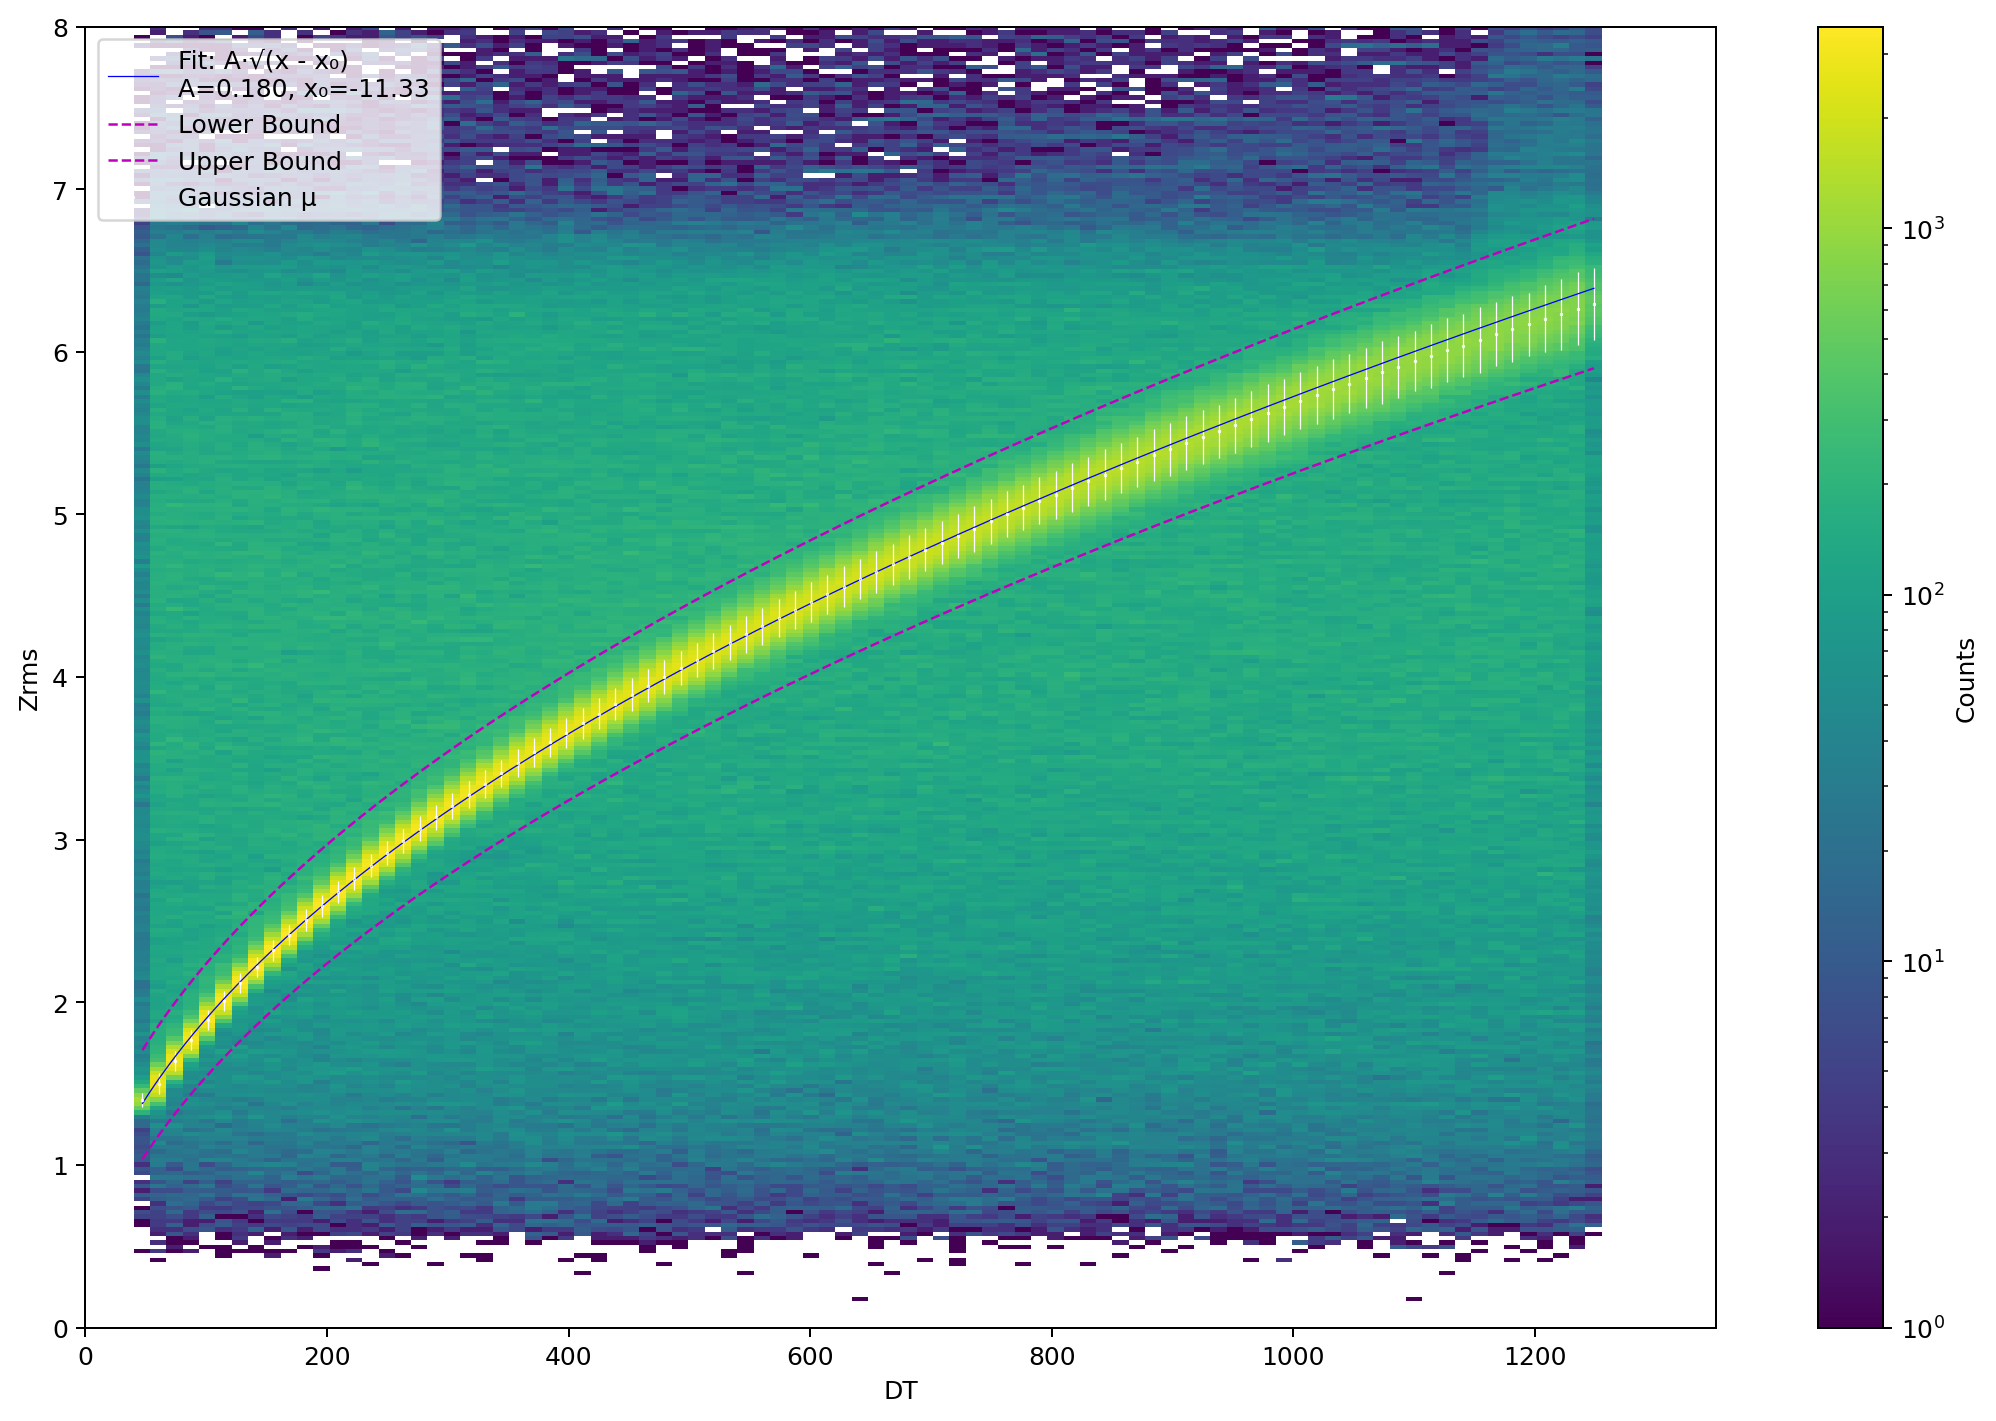

In [19]:
def sqrt_function(x, A, x0):
    return A * np.sqrt(x - x0)

counts, xedges, yedges = np.histogram2d(
    df_testrun[(df_testrun['DT'] > 50) & (df_testrun['DT'] < 1250)]['DT'],
    df_testrun[(df_testrun['DT'] > 50) & (df_testrun['DT'] < 1250)]['Zrms'],
    bins=(100, 300), range=([0, 1350], [0, 8])
)

dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts, xedges, yedges)

popt_sqrt, pcov_sqrt = curve_fit(sqrt_function, dt_centers, mean_vals, sigma=mean_errs, p0=[0.1,-0.1])

plt.figure(figsize=(12, 8), dpi=180)

# Plot 2D histogram
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    norm = LogNorm()
)

# Overlay mean values and fit
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')
xfit = np.linspace(min(dt_centers), max(dt_centers), 500)

plt.plot(xfit, sqrt_function(xfit, *popt_sqrt), 'b-', linewidth=.5, label=f'Fit: A·√(x - x₀)\nA={popt_sqrt[0]:.3f}, x₀={popt_sqrt[1]:.2f}')

y_center = sqrt_function(xfit, *popt_sqrt)
lower_bound = y_center - 0.3 - 0.03 * y_center
upper_bound = y_center + 0.3 + 0.02 * y_center

plt.plot(xfit, lower_bound, 'm--', linewidth=1., label='Lower Bound')
plt.plot(xfit, upper_bound, 'm--', linewidth=1., label='Upper Bound')

# Labels and aesthetics
plt.xlabel('DT')
plt.ylabel('Zrms')
plt.colorbar(label='Counts')
plt.grid(False)
plt.legend(fontsize=10)
plt.tight_layout()

In [20]:
df_testrun_sel_diff = df_testrun[ (df_testrun['Zrms'] > sqrt_function(df_testrun['DT'],*popt_sqrt)-0.3-0.03*sqrt_function(df_testrun['DT'],*popt_sqrt) ) 
                    & (df_testrun['Zrms'] < sqrt_function(df_testrun['DT'],*popt_sqrt)+0.3+0.02*sqrt_function(df_testrun['DT'],*popt_sqrt) )  ]

print(f"NEvent filtered road : {len(np.unique(df_testrun_sel_diff['event']))}")
print(f"eff:{(len(np.unique(df_testrun_sel_diff['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

/Users/samuele/Software/miniforge3/envs/IC/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


NEvent filtered road : 1572883
eff:87.69%


In [21]:
df_testrun_single_s1_peak = df_testrun_sel_diff.groupby('time').filter(lambda x: (x['s1_peak'].count() == 1) & (x['s2_peak'].count() == 1))

print(f"NEvent filtered road : {len(np.unique(df_testrun_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1283901
eff:71.58%


In [22]:
df_testrun_single_s1_peak_geo = df_testrun_single_s1_peak[ (df_testrun_single_s1_peak['DT']<1350) & (np.sqrt(df_testrun_single_s1_peak['X']**2 + df_testrun_single_s1_peak['Y']**2)<480 )   ]

print(f"NEvent filtered road : {len(np.unique(df_testrun_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak_geo['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1283901
eff:70.98%


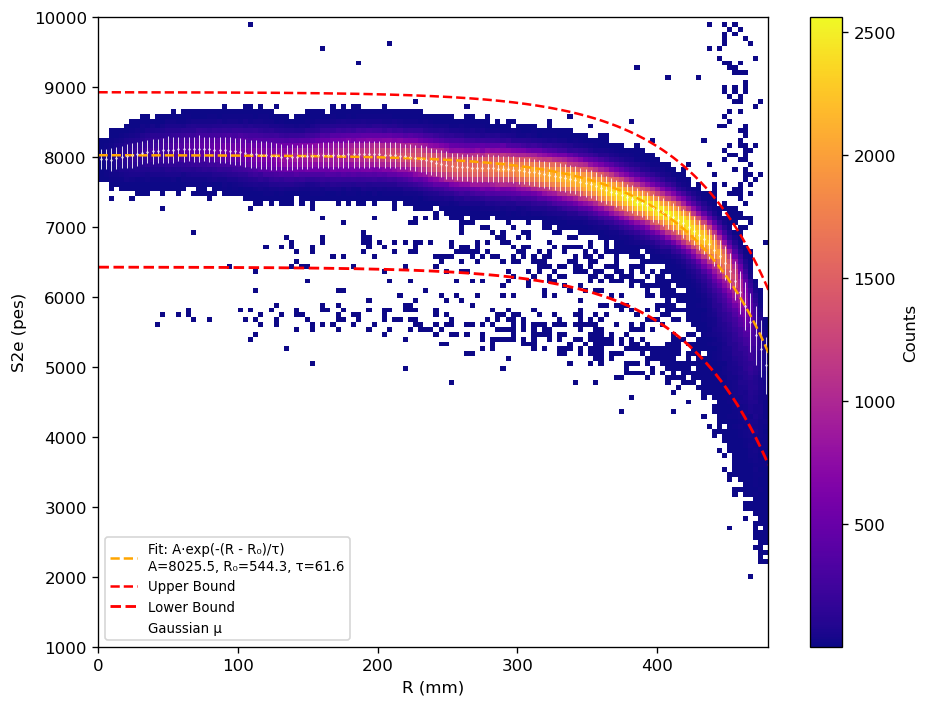

In [23]:
# Step 3: Fit with exponential model
def expo_model(R, A, R0, tau):
    return A *(1- np.exp((R - R0) / tau))

fig = plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(df_testrun_single_s1_peak_geo['R'], df_testrun_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts2, xedges2, yedges2)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

p0=[8000, 600, 100]
popt, _ = curve_fit(expo_model, dt_centers, mean_vals, p0=p0)

pcm = plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.colorbar(pcm, label='Counts')

plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')

r_fit = np.linspace(0, 480, 500)
plt.plot(r_fit, expo_model(r_fit, *popt), color='orange', linestyle='--', linewidth=1.5, label=f'Fit: A·exp(-(R - R₀)/τ)\nA={popt[0]:.1f}, R₀={popt[1]:.1f}, τ={popt[2]:.1f}')
plt.plot(r_fit, expo_model(r_fit, *popt)+900, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound')
plt.plot(r_fit, expo_model(r_fit, *popt)-1600, color='red', linestyle='--', linewidth=1.7, label=f'Lower Bound')

plt.legend(fontsize=8)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
df_testrun_single_s1_peak_geo = df_testrun_single_s1_peak_geo[(df_testrun_single_s1_peak_geo['S2e'] >= expo_model(df_testrun_single_s1_peak_geo['R'], *popt) - 1600) & 
                             (df_testrun_single_s1_peak_geo['S2e'] <= expo_model(df_testrun_single_s1_peak_geo['R'], *popt) + 900)]

print(f"NEvent filtered road : {len(np.unique(df_testrun_single_s1_peak_geo['event']))}")
print(f"eff:{(len(np.unique(df_testrun_single_s1_peak_geo['event']))/len(np.unique(df_testrun['event'])))*100:.2f}%")

NEvent filtered road : 1267361
eff:70.65%


In [26]:
Krdf_test = af.correct_S2e(df_testrun_single_s1_peak_geo, krmap_loaded, rmax=480.0, zmax=1350.0)

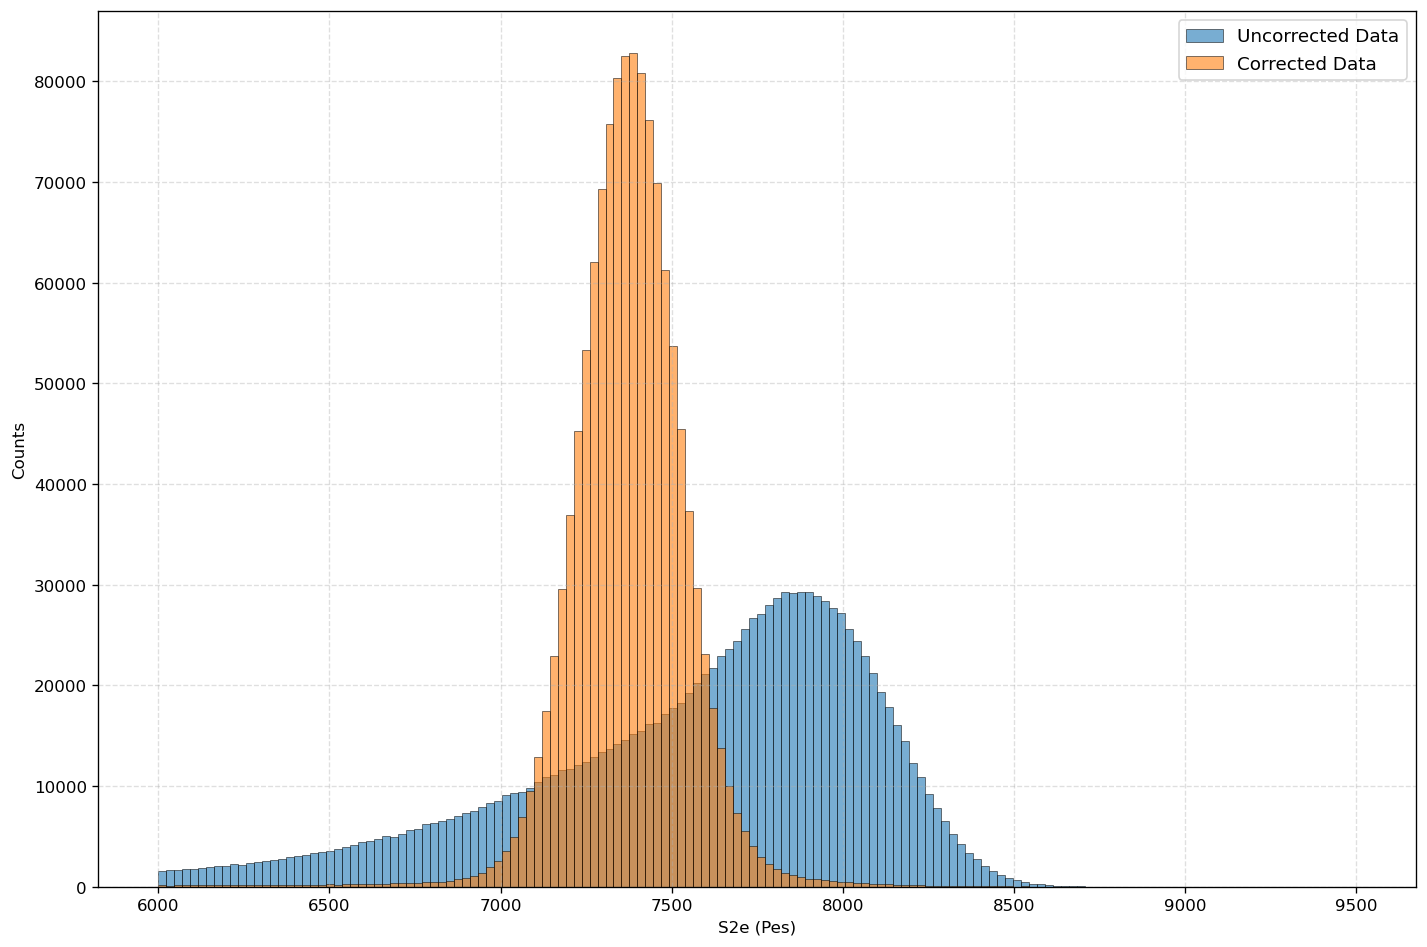

In [27]:
plt.figure(figsize=(12, 8), dpi=120)
# Plot S2e histogram
plt.hist(Krdf_test['S2e'], bins=150, range=(6000, 9500), alpha=0.6 , color='tab:blue', edgecolor='black', linewidth=0.5, label='Uncorrected Data')
# Plot Epes histogram
plt.hist(Krdf_test['Epes'], bins=150, range=(6000, 9500), alpha=0.6, color='tab:orange', edgecolor='black', linewidth=0.5, label='Corrected Data')

# Aesthetic settings
plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

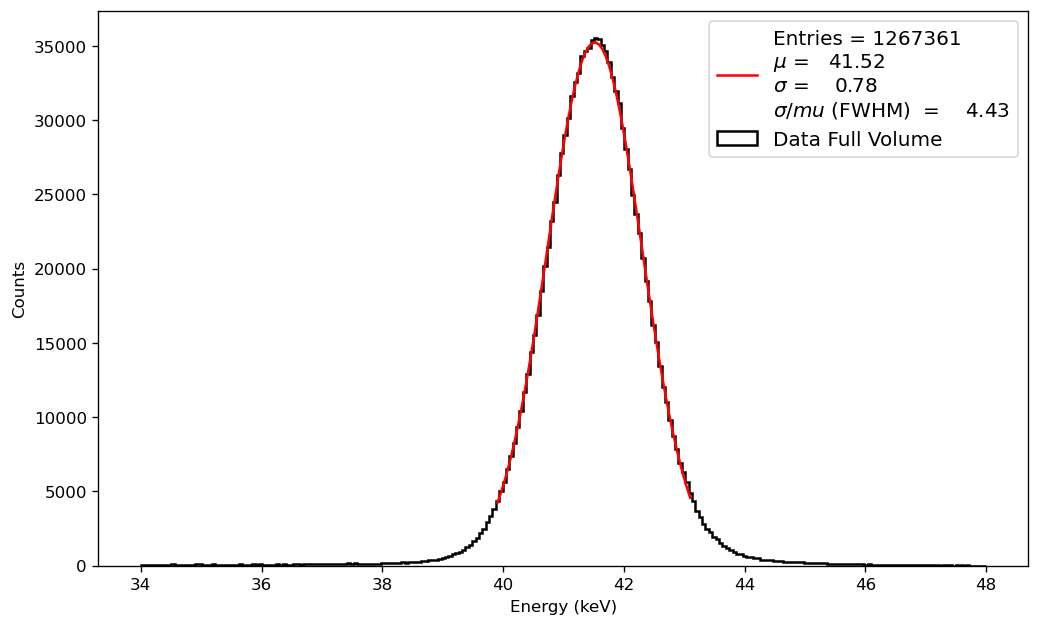

In [28]:
hp = af.HistoPar(var = Krdf_test['Epes']/Krdf_test['Epes'].mean()*41.5, nbins = 250, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.7)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data Full Volume")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

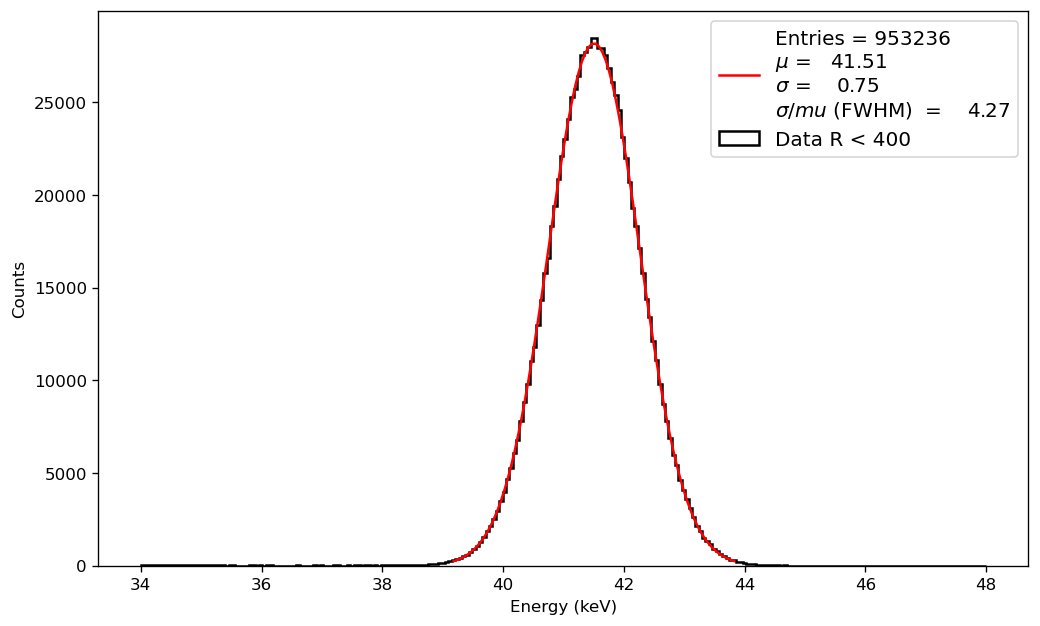

In [29]:
hp = af.HistoPar(var = Krdf_test[Krdf_test['R']<400]['Epes']/Krdf_test[Krdf_test['R']<400]['Epes'].mean()*41.5, nbins = 250, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 400")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

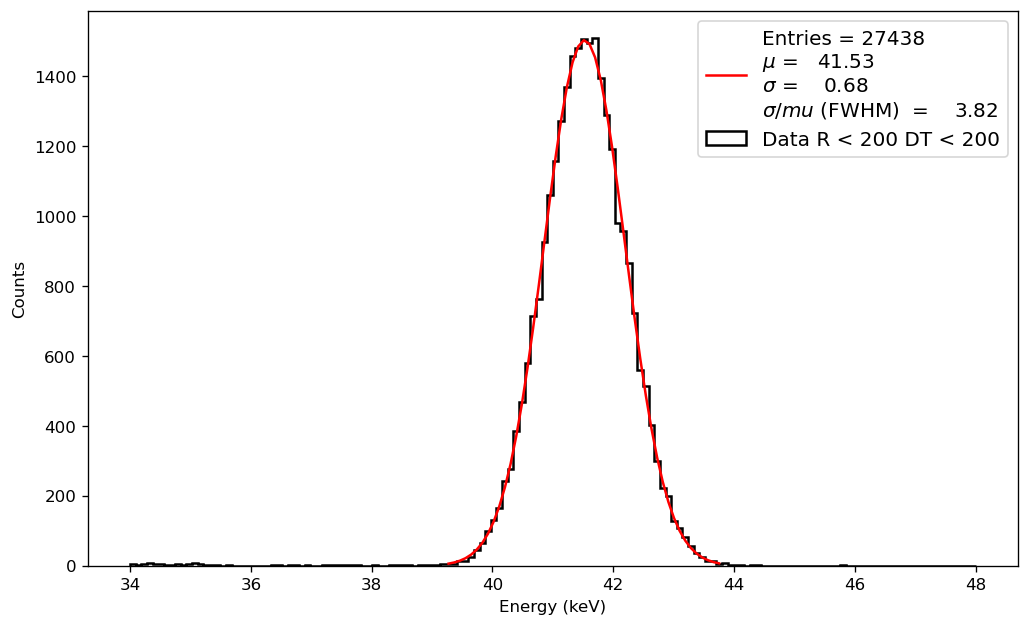

In [30]:
hp = af.HistoPar(var = Krdf_test[(Krdf_test['R']<200) & (Krdf_test['DT']<200)]['Epes']/Krdf_test[(Krdf_test['R']<200) & (Krdf_test['DT']<200)]['Epes'].mean()*41.5, nbins = 150, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 200 DT < 200")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')